In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import itertools
from keras.layers import *
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, losses

from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [4]:
num_channels = 3
pixel_size = 201
padding_ = 'same'
data_format_ = 'channels_last'
actv_ = 'relu'

In [6]:
# CNN architecture
model = Sequential()
# CONV1
model.add(Conv2D(filters=10, kernel_size=(3,3), strides=(1,1), input_shape=(pixel_size, pixel_size, num_channels),
                 padding=padding_, data_format=data_format_))
model.add(normalization.BatchNormalization(axis=1))
model.add(Activation(actv_))
# CONV2
#model.add(Conv2D(filters=10, kernel_size=(3,3), strides=(1,1), padding=padding_, data_format=data_format_))
#model.add(normalization.BatchNormalization(axis=1))
#model.add(Activation(actv_))
# POOL1
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding=padding_, data_format=data_format_))
# CONV3
model.add(Conv2D(filters=20, kernel_size=(3,3), strides=(1,1), padding=padding_, data_format=data_format_))
model.add(normalization.BatchNormalization(axis=1))
model.add(Activation(actv_))
# CONV4
#model.add(Conv2D(filters=20, kernel_size=(3,3), strides=(1,1), padding=padding_, data_format=data_format_))
#model.add(normalization.BatchNormalization(axis=1))
#model.add(Activation(actv_))
# POOL2
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding=padding_, data_format=data_format_))
# CONV5
model.add(Conv2D(filters=40, kernel_size=(3,3), strides=(1,1), padding=padding_, data_format=data_format_))
model.add(normalization.BatchNormalization(axis=1))
model.add(Activation(actv_))
# CONV6
#model.add(Conv2D(filters=40, kernel_size=(3,3), strides=(1,1), padding=padding_, data_format=data_format_))
#model.add(normalization.BatchNormalization(axis=1))
#model.add(Activation(actv_))
# CONV7
#model.add(Conv2D(filters=40, kernel_size=(3,3), strides=(1,1), padding=padding_, data_format=data_format_))
#model.add(normalization.BatchNormalization(axis=1))
#model.add(Activation(actv_))
# CONV8
#model.add(Conv2D(filters=40, kernel_size=(3,3), strides=(1,1), padding=padding_, data_format=data_format_))
#model.add(normalization.BatchNormalization(axis=1))
#model.add(Activation(actv_))
# POOL3
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', data_format=data_format_))
# FLATTEN
model.add(Flatten())
model.add(Dense(50, activation=actv_))
model.add(Dense(50, activation=actv_))
model.add(Dense(17, activation='softmax'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 201, 201, 10)      280       
_________________________________________________________________
batch_normalization_7 (Batch (None, 201, 201, 10)      804       
_________________________________________________________________
activation_7 (Activation)    (None, 201, 201, 10)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 101, 101, 10)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 101, 101, 20)      1820      
_________________________________________________________________
batch_normalization_8 (Batch (None, 101, 101, 20)      404       
_________________________________________________________________
activation_8 (Activation)    (None, 101, 101, 20)      0         
__________

In [8]:
# Split training and test sets
test_samples_df = pd.read_csv('test_samples.csv')
metadata_df = pd.read_csv('train_metadata_codes.csv')
training_df = metadata_df[~metadata_df.cell_code.isin(test_samples_df.cell_code.values)].reset_index()
training_df = training_df.sample(frac=1).reset_index(drop=True)
test_df = metadata_df[metadata_df.cell_code.isin(test_samples_df.cell_code.values)].reset_index()
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [9]:
def get_X_y(df):
    X = np.array([imread('training/%s' % path) for path in df.rel_path.values])
    f = pd.factorize(df.moa, sort=True)
    y = np.zeros((f[0].shape[0], len(set(f[0]))))
    y[np.arange(f[0].shape[0]), f[0].T] = 1
    targets = f[1]
    
    return X, y, targets

In [11]:
X_train, y_train, targets_train = get_X_y(training_df)

In [12]:
X_train.shape

(49567, 201, 201, 3)

In [13]:
y_train.shape

(49567, 17)

In [14]:
targets_train

Index(['AMPA', 'CDK', 'Ca2', 'Cdc25', 'DNAMetabolism', 'DNA_intercalation',
       'EGFR', 'MEK', 'ROCK', 'TopoII', 'Tubulin', 'adrenoceptor', 'cMyc',
       'cellcycle', 'dopaminereceptor', 'eNOS', 'rac1'],
      dtype='object')

In [15]:
X_test, y_test, targets_test = get_X_y(test_df)

In [16]:
X_test.shape

(1700, 201, 201, 3)

In [17]:
y_test.shape

(1700, 17)

In [18]:
targets_test

Index(['AMPA', 'CDK', 'Ca2', 'Cdc25', 'DNAMetabolism', 'DNA_intercalation',
       'EGFR', 'MEK', 'ROCK', 'TopoII', 'Tubulin', 'adrenoceptor', 'cMyc',
       'cellcycle', 'dopaminereceptor', 'eNOS', 'rac1'],
      dtype='object')

In [19]:
# Hyper-parameters
params = {'percent_to_valid': 0.2,
          'num_epochs': 200,
          'batch_size': 256}

In [20]:
model_weights = 'cnn2_weights.hdf5'

# Optimization method
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adadelta(), metrics=['accuracy'])

# Fit training data
earlyStopping = EarlyStopping(patience=5, verbose=True, monitor='val_loss')
mcp_save = ModelCheckpoint(filepath=model_weights, save_best_only=True, monitor='val_loss', mode='min')
hist = model.fit(X_train, y_train, epochs=params['num_epochs'], batch_size=params['batch_size'], 
                 validation_split=params['percent_to_valid'], callbacks=[earlyStopping, mcp_save])

Train on 39653 samples, validate on 9914 samples
Epoch 1/200
39653/39653 [==============================] - 174s - loss: 2.7707 - acc: 0.1052 - val_loss: 2.6689 - val_acc: 0.1202
Epoch 2/200
39653/39653 [==============================] - 170s - loss: 2.6374 - acc: 0.1199 - val_loss: 2.5850 - val_acc: 0.1396
Epoch 3/200
39653/39653 [==============================] - 170s - loss: 2.5650 - acc: 0.1398 - val_loss: 2.5253 - val_acc: 0.1539
Epoch 4/200
39653/39653 [==============================] - 171s - loss: 2.5154 - acc: 0.1501 - val_loss: 2.4985 - val_acc: 0.1582
Epoch 5/200
39653/39653 [==============================] - 171s - loss: 2.4851 - acc: 0.1591 - val_loss: 2.5222 - val_acc: 0.1514
Epoch 6/200
39653/39653 [==============================] - 171s - loss: 2.4632 - acc: 0.1655 - val_loss: 2.4753 - val_acc: 0.1625
Epoch 7/200
39653/39653 [==============================] - 171s - loss: 2.4465 - acc: 0.1710 - val_loss: 2.4692 - val_acc: 0.1670
Epoch 8/200
39653/39653 [================

In [21]:
#model.load_weights(model_weights)
model.save('cnn2_model.h5')

1700/1700 [==============================] - 3s     

Test loss: 2.41
Test acc: 24.06%
F1-Score: 0.24


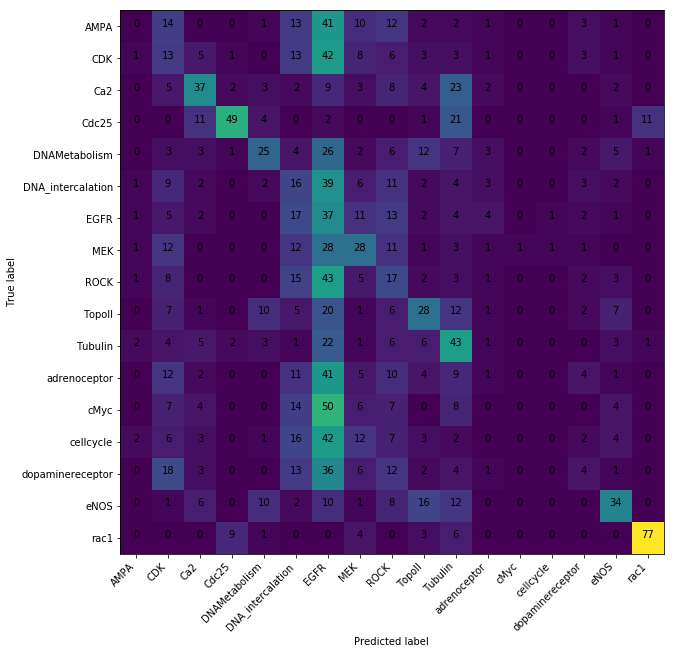

In [38]:
# Evaluate model
#model = load_model('cnn2_model.h5')
score = model.evaluate(X_test, y_test, batch_size=params['batch_size'])
print('\nTest %s: %.2f' % (model.metrics_names[0], score[0]))
print('Test %s: %.2f%%' % (model.metrics_names[1], score[1]*100))

# Make predictions
targets = targets_test
y_pred = model.predict(X_test, batch_size=params['batch_size'])
y_pred = [targets[i] for i in np.argmax(y_pred, axis=1)]
y_true = [targets[i] for i in np.argmax(y_test, axis=1)]

# Print prediction performance on F1-score
f1 = f1_score(y_true, y_pred, average='macro')  
print('F1-Score: %.2f' % f1)

unpredicted_classes = list(set(y_true) - set(y_pred))
if len(unpredicted_classes):
    print('THESE CLASSES ARE NOT PREDICTED - SCORING WILL FAIL!')
    print(unpredicted_classes)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred, targets)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
tick_marks = np.arange(len(targets))
plt.xticks(tick_marks, targets, rotation=45, ha='right')
plt.yticks(tick_marks, targets)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('cnn_cm.png', bbox_inches='tight')

In [30]:
df = pd.read_csv('validation_metadata.csv')
df.head()

,rel_path,cell_code
0,single_cell_KuQJTlfiFW.tiff,KuQJTlfiFW
1,single_cell_OHLCBK5YUr.tiff,OHLCBK5YUr
2,single_cell_hdDTiJ9PFF.tiff,hdDTiJ9PFF
3,single_cell_UZtW0gA3q5.tiff,UZtW0gA3q5
4,single_cell_IAKfYa4KWb.tiff,IAKfYa4KWb


In [31]:
X_validation = np.array([imread('validation/%s' % path) for path in df.rel_path.values])
validation_cells = df.cell_code.values

In [32]:
metadata_df = pd.read_csv('train_metadata_codes.csv')
metadata_df.head()
f = pd.factorize(metadata_df.moa, sort=True)
targets = f[1]

In [33]:
# Predict target probabilities
y_pred = model.predict(X_validation, batch_size=params['batch_size'])
df_valid_prob = pd.DataFrame(columns=targets, data=y_pred)
df_valid_prob.insert(0, 'cell_code', validation_cells)
# Save predictions
df_valid_prob.to_csv('cnn2_probabilities.csv', index=False)

In [35]:
# Predictions on maximum probabilities
df_valid_pred = pd.DataFrame(columns = ['cell_code', 'prediction'])
df_valid_pred['cell_code'] = df_valid_prob['cell_code']
df_valid_pred['prediction'] = [targets[i] for i in np.argmax(y_pred, axis=1)]
df_valid_pred.to_csv('cnn2_predictions.csv', index=False)